In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from sklearn.utils.class_weight import compute_class_weight
import numpy as np, os
import matplotlib.pyplot as plt

In [ ]:
# Rutas de las carpetas de imagenes para entrenamiento y testing
TRAIN_DIR = "/content/drive/MyDrive/Datasets/ISIC 2024 Dataset/ISIC_2024_Resize224/train"
TEST_DIR = "/content/drive/MyDrive/Datasets/ISIC 2024 Dataset/ISIC_2024_Resize224/test"

IMG_SIZE = (224, 224)   # Tamaño de la imagen
BATCH_SIZE = 16         # Tamaño del batch
EPOCHS = 100            # Cantidad de épocas

In [ ]:
# Etapa de carga del dataset

# Dataset de entrenamiento
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,    # Tamaño de imagen, que luego espera MobileNet
    batch_size=BATCH_SIZE,  # Tamaño del batch que entrena
    label_mode='binary'
)

# Dataset de validación
val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,    # Tamaño de imagen, que luego espera MobileNet
    batch_size=BATCH_SIZE,  # Tamaño del batch que entrena
    label_mode='binary'
)

# Dataset de testing
test_data = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    label_mode='binary',
    image_size=IMG_SIZE,    # Tamaño de imagen, que luego espera MobileNet
    batch_size=BATCH_SIZE,  # Tamaño del batch que entrena
    shuffle=False
)

Found 12578 files belonging to 2 classes.
Using 10063 files for training.
Found 12578 files belonging to 2 classes.
Using 2515 files for validation.
Found 2000 files belonging to 2 classes.


In [ ]:
# Normalizacion y optimizacion del pipeline de datos con prefetching

def normalize_img(image, label):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1.0
    return image, label

train_ds = train_ds.map(normalize_img)
val_ds = val_ds.map(normalize_img)
test_data = test_data.map(normalize_img)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Calculamos los pesos de cada clase
# Chequeamos clases y cantidad de imagenes en cada una
classes = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
counts = [len(os.listdir(os.path.join(TRAIN_DIR, c))) for c in classes]

# Calculamos los pesos balanceados
class_weights_arr = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(classes)),
    y=np.concatenate([[i]*count for i,count in enumerate(counts)])
)

# Lo convertimos en un diccionario, luego se usara en el entrenamiento
class_weights = dict(enumerate(class_weights_arr))
print("Clases encontradas:", classes)
print("Pesos calculados para las clases:", class_weights)

Clases encontradas: ['Benign', 'Malignant']
Pesos calculados para las clases: {0: np.float64(1.0), 1: np.float64(1.0)}


In [ ]:
# Etapa de construccion del modelo

input_layer = tf.keras.Input(shape=(224, 224, 3))   # Capa de entrada, 224 x 224 y RGB (Tercer parametro)

# Data augmentation para que no se sobreajuste o generalice durante el entrenamiento
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.20),
    layers.RandomZoom(0.20),
])

# Carga de modelo preentrenado MobileNet
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

base_model.trainable = False    # Congelamos el modelo base

# Construccion del modelo
model = tf.keras.Sequential([
    input_layer,
    data_augmentation,  # Aumentacion de datos
    base_model,         # Modelo base

    layers.GlobalAveragePooling2D(),

    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')   # Salida binaria
])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Compilamos el modelo con un optimizador Adam

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss="binary_crossentropy",
    metrics=["accuracy", AUC(name="auc")]
)

# Resumen del modelo para ver las capas, como entran y como salen
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,081,793 (11.76 MB)

 Trainable params: 822,017 (3.14 MB)

 Non-trainable params: 2,259,776 (8.62 MB)

In [ ]:
# EarlyStopping con monitoreo de val_loss
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
)

# ReduceLROnPlateau para ajustar la tasa de aprendizaje cuando la perdida no mejora
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=4,
    factor=0.5,
    min_lr=0.000001,
)

In [ ]:
# Inicio de entrenamiento
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
629/629 ━━━━━━━━━━━━━━━━━━━━ 1310s 2s/step - accuracy: 0.7074 - auc: 0.7829 - loss: 10.1085 - val_accuracy: 0.8604 - val_auc: 0.9388 - val_loss: 4.7834 - learning_rate: 5.0000e-04
Epoch 2/100
629/629 ━━━━━━━━━━━━━━━━━━━━ 46s 74ms/step - accuracy: 0.8047 - auc: 0.8795 - loss: 4.0811 - val_accuracy: 0.8616 - val_auc: 0.9365 - val_loss: 2.1690 - learning_rate: 5.0000e-04
Epoch 3/100
629/629 ━━━━━━━━━━━━━━━━━━━━ 47s 74ms/step - accuracy: 0.8023 - auc: 0.8834 - loss: 1.9483 - val_accuracy: 0.8604 - val_auc: 0.9392 - val_loss: 1.1152 - learning_rate: 5.0000e-04
Epoch 4/100
629/629 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - accuracy: 0.8242 - auc: 0.9013 - loss: 1.0609 - val_accuracy: 0.8632 - val_auc: 0.9370 - val_loss: 0.7298 - learning_rate: 5.0000e-04
Epoch 5/100
629/629 ━━━━━━━━━━━━━━━━━━━━ 47s 74ms/step - accuracy: 0.8210 - auc: 0.8969 - loss: 0.7546 - val_accuracy: 0.8600 - val_auc: 0.9400 - val_loss: 0.5701 - learning_rate: 5.0000e-04
Epoch 6/100
629/629 ━━━━━━━━━━━━━━━━━━━━ 48s

In [ ]:
# Guardamos modelo entrenado (Sin fine-tuning)
save_path = "/content/drive/MyDrive/skin-cancer/saved_models/modelo_benigno_maligno_v8.keras"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
model.save(save_path)

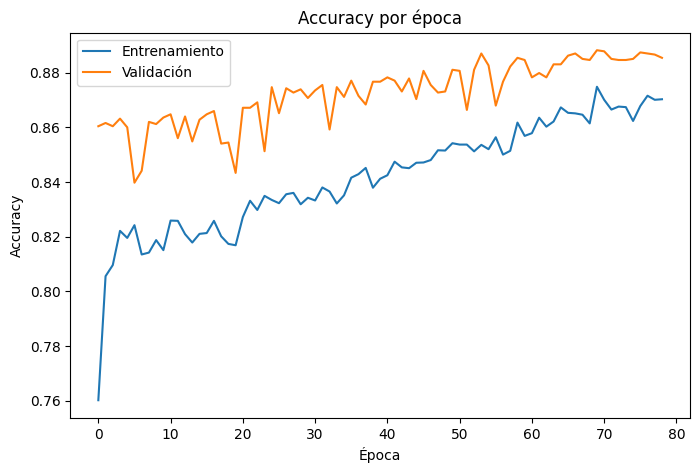

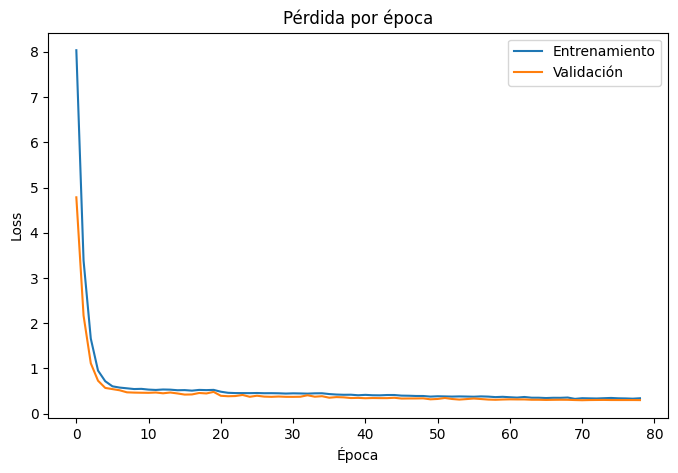

In [ ]:
# Grafica de AUC del entrenamiento
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title("Accuracy por época")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Grafica de loss del entrenamiento
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title("Pérdida por época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#Preparación para Fine-Tuning
base_model.trainable = True # Permitimos a MobileNetV2 que entrene

print(f"Número total de capas en MobileNetV2: {len(base_model.layers)}")

fine_tune_at = 100  # Capas que se van a entrenar

# Congelamos las capas
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Número total de capas en MobileNetV2: 154


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,081,793 (11.76 MB)

 Trainable params: 2,683,457 (10.24 MB)

 Non-trainable params: 398,336 (1.52 MB)

In [ ]:
# Etapa de fine-tuning

print("\nIniciando Fine-Tuning...")

# Entrenamos por unas pocas épocas más
fine_tune_epochs = 20
initial_training_epochs = 50
total_epochs = initial_training_epochs + fine_tune_epochs

early_stop_ft = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_ft = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0000001)

# Entrenamiento del modelo con fine-tuning
history_ft = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=initial_training_epochs,
    validation_data=val_ds,
    class_weight=class_weights,
    callbacks=[early_stop_ft, reduce_lr_ft]
)
print("Fine-Tuning completado.")


Iniciando Fine-Tuning...
Epoch 51/70
629/629 ━━━━━━━━━━━━━━━━━━━━ 74s 91ms/step - accuracy: 0.7869 - loss: 0.5057 - val_accuracy: 0.7511 - val_loss: 0.7447 - learning_rate: 1.0000e-05
Epoch 52/70
629/629 ━━━━━━━━━━━━━━━━━━━━ 58s 92ms/step - accuracy: 0.8249 - loss: 0.4206 - val_accuracy: 0.7861 - val_loss: 0.5360 - learning_rate: 1.0000e-05
Epoch 53/70
629/629 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.8421 - loss: 0.3914 - val_accuracy: 0.8417 - val_loss: 0.3842 - learning_rate: 1.0000e-05
Epoch 54/70
629/629 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.8501 - loss: 0.3736 - val_accuracy: 0.8684 - val_loss: 0.3328 - learning_rate: 1.0000e-05
Epoch 55/70
629/629 ━━━━━━━━━━━━━━━━━━━━ 56s 88ms/step - accuracy: 0.8579 - loss: 0.3611 - val_accuracy: 0.8827 - val_loss: 0.3083 - learning_rate: 1.0000e-05
Epoch 56/70
629/629 ━━━━━━━━━━━━━━━━━━━━ 56s 88ms/step - accuracy: 0.8514 - loss: 0.3570 - val_accuracy: 0.8779 - val_loss: 0.3117 - learning_rate: 1.0000e-05
Epoch 57/70
629/629 

In [ ]:
# Guardar el modelo afinado
save_path_ft = "//content/drive/MyDrive/skin-cancer/saved_models/modelo_benigno_maligno_v8_ft.keras"
os.makedirs(os.path.dirname(save_path_ft), exist_ok=True)
model.save(save_path_ft)


Gráficos del Fine-Tuning:


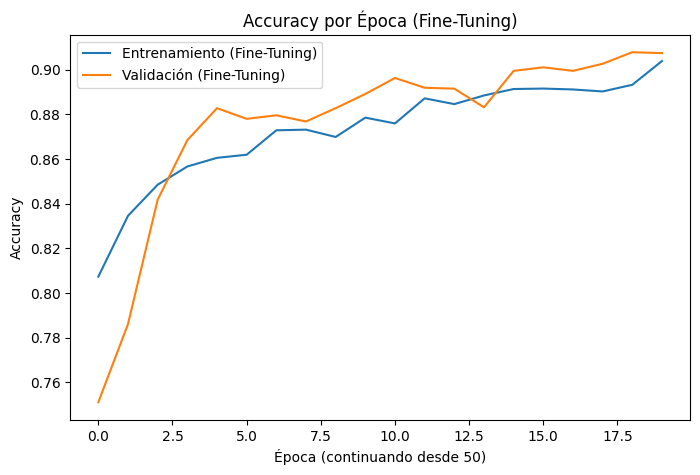

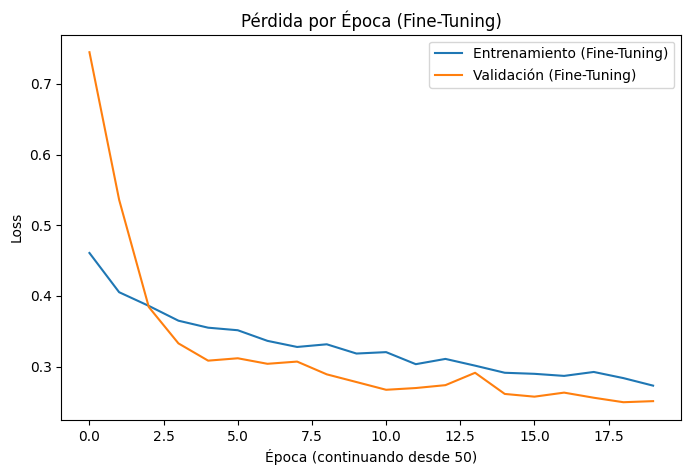

In [ ]:
#Graficar los resultados del Fine-Tuning

print("\nGráficos del Fine-Tuning:")

# Gráfico de Precisión (Fine-Tuning)
plt.figure(figsize=(8,5))
plt.plot(history_ft.history['accuracy'], label='Entrenamiento (Fine-Tuning)')
plt.plot(history_ft.history['val_accuracy'], label='Validación (Fine-Tuning)')
plt.title("Accuracy por Época (Fine-Tuning)")
plt.xlabel(f"Época (continuando desde {initial_training_epochs})")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Gráfico de Pérdida (Fine-Tuning)
plt.figure(figsize=(8,5))
plt.plot(history_ft.history['loss'], label='Entrenamiento (Fine-Tuning)')
plt.plot(history_ft.history['val_loss'], label='Validación (Fine-Tuning)')
plt.title("Pérdida por Época (Fine-Tuning)")
plt.xlabel(f"Época (continuando desde {initial_training_epochs})")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
print("\nEvaluando el modelo en el conjunto de prueba:")

loss, accuracy = model.evaluate(test_data)

print(f"\nResultado Final:")
print(f"  - Pérdida (Loss) en prueba: {loss:.4f}")
print(f"  - Precisión (Accuracy) en prueba: {accuracy:.4f} (o {accuracy*100:.2f}%)")


Evaluando el modelo en el conjunto de prueba:
125/125 ━━━━━━━━━━━━━━━━━━━━ 354s 3s/step - accuracy: 0.9297 - loss: 0.1950

Resultado Final:
  - Pérdida (Loss) en prueba: 0.2486
  - Precisión (Accuracy) en prueba: 0.9065 (o 90.65%)
